Keras CNN+RNN+DNN으로 음성 인식하기

1. 패키지 수입 및 파라미터 설정

In [ ]:
# 1번 블럭
# 패키지 수입
import os
import numpy as np
import random

from time import time
from sklearn.preprocessing import LabelEncoder
# 원핫 인코딩
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# 데이터 처리 진행 상황을 표시
from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt

# 케라스 인공신경망
from keras.layers import Bidirectional, BatchNormalization
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv1D, Input, MaxPool1D
from keras.models import Model

2. 데이터 불러오기 및 선처리

In [ ]:
# 2번 블럭
# 파라미터 지정
MY_SPLIT = 0.8
MY_HIDDEN = 128  # RNN 셀의 복잡 정도
MY_DROP = 0.3    # dropout 비율
MY_BATCH = 128   # 매번 가져와서 처리하는 데이터 수
MY_EPOCH = 100   # 반복 학습 수

MY_PATH = '/content/drive/MyDrive/dataset/audio'

# 모드 선택
DATA_MODE = 0  # 1이면 음성 데이터 처리, 0이면 통과(= 이미 처리해서 저장한 데이터 불러오기)
TRAIN_MODE = 0 # 1이면 학습 진행 0이면 통과 (= 이미 처리해서 저장한 데이터 불러오기)

# 데이터 참고 리스트 초기화
all_wave = []  # 음성 데이터
all_label = [] # 라벨 정보


22050
[-6.6473804e-05 -2.6208448e-04 -3.8669028e-04 ... -2.3058777e-04
 -8.9272929e-05  0.0000000e+00]


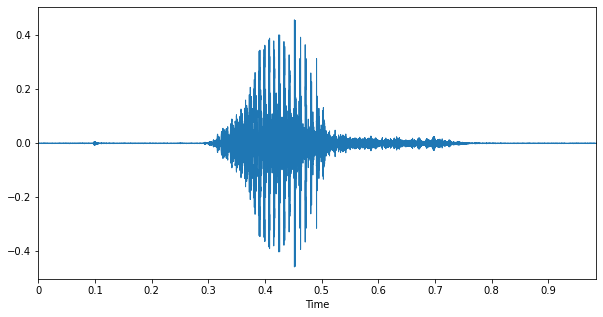

In [ ]:
# 3번블럭
# 샘플 오디오 확인
labels = ['go', 'happy', 'seven', 'stop', 'yes']

# 샘플 오디오 파일 읽기
sound, rate = librosa.load('/content/drive/MyDrive/dataset/SKL-yes.wav')
print(rate)
print(sound)

# 오디오 데이터 시각화
plt.figure(figsize=(10,5))
librosa.display.waveplot(sound,rate)

In [ ]:
# 4번 블럭
# 오디오 리샘플링 처리
# 시간 오래 걸림
def read_wav():
    all_wave = []
    all_label = []

    print('resampling 시작')
    begin = time()

    # tqdm 함수로 진행 상황 출력
    for label in tqdm(labels):
        path = MY_PATH + '/' + label
        #print(path)
        waves = [f for f in os.listdir(path)]
        #print(waves)

        # wav 파일 하나씩 처리
        for wav in waves:
            file = path + '/' + wav
            #print(file)
            sound, rate = librosa.load(file)

            # 8KHz로 다운 샘플링
            #print(len(sound))
            new = librosa.resample(sound,
                                   orig_sr=rate,
                                   target_sr=8000)
            #print(len(new))

            # 성공적으로 8KHz 된 데이터만 저장
            if (len(new) == 8000):
                all_wave.append(new)
                all_label.append(label)

    end = time()
    print('총 다운 샘플링 시간: {:.2f}'.format(end-begin))

    return all_wave, all_label

In [ ]:
# 5번 블럭
# 라벨 처리 (token 처리)
def do_label():
    global all_label, all_wave

    #print('전', all_label)
    encoder = LabelEncoder()
    all_label = encoder.fit_transform(all_label)
    #print('전', all_label)
  
    # 라벨을 원핫 인코딩 처리
    # to_categorical 함수는 결과를 numpy로 저장
    all_label = to_categorical(all_label, len(labels))
    #print('후', all_label)
    #print(type(all_label))

    # 음성 데이터를 numpy로 전환
    #print('전:', type(all_wave))
    all_wave = np.array(all_wave)
    #print('후:', type(all_wave))

    print('전:', all_wave.shape)
    all_wave = all_wave.reshape(-1, 8000, 1) # reshape이유는 차원을 하나 늘려줘야 LSTM에서 처리 가능해서
    print('후:', all_wave.shape)

    return all_wave, all_label

In [ ]:
# 6번 블럭
# 데이터 처리 컨트롤 타워
if DATA_MODE:
    all_wave, all_label = read_wav()
    all_wave, all_label = do_label()

    # 파일에 numpy 저장
    with open('speech.npy', 'wb') as file:
        np.save(file, all_wave)
        np.save(file, all_label)

    print('데이터 처리 끝')

else:
    with open('/content/drive/MyDrive/dataset/speech.npy', 'rb') as file:
        all_wave = np.load(file)
        all_label = np.load(file)

# 최종 데이터 모양 확인
print('음성 데이터:', all_wave.shape)
print('라벨 데이터:', all_label.shape)


음성 데이터: (889, 8000, 1)
라벨 데이터: (889, 5)


In [ ]:
# 7번 블럭
# 데이터 4분할

X_train, X_test, Y_train, Y_test = train_test_split(all_wave,
                                                    all_label,
                                                    train_size=MY_SPLIT,
                                                    shuffle =True)

# 4분할 데이터 모양
print('학습용 입력 데이터 모양:',X_train.shape)
print('학습용 출력 데이터 모양:',Y_train.shape)

print('평가용 입력 데이터 모양:',X_test.shape)
print('평가용 입력 데이터 모양:',Y_test.shape)

# 샘플 출력
pick = 123
print(X_train[pick])
print(Y_train[pick])

학습용 입력 데이터 모양: (711, 8000, 1)
학습용 출력 데이터 모양: (711, 5)
평가용 입력 데이터 모양: (178, 8000, 1)
평가용 입력 데이터 모양: (178, 5)
[[-7.4961366e-07]
 [ 5.7877241e-07]
 [-3.9388374e-07]
 ...
 [ 2.6460035e-05]
 [ 8.6496793e-06]
 [ 1.2013292e-05]]
[1. 0. 0. 0. 0.]


3. 인공 신경망 구현

In [ ]:
# 8번 블럭

# 입력층 구현

# 학습용 데이터 하나의 모양 지정
my_input = Input(shape=(8000, 1))

# 2번 그룹 구현
x = BatchNormalization()(my_input)
# 커널 = 필터
x = Conv1D(filters=8, 
           kernel_size=13, 
           padding='valid', 
           strides=1, 
           activation='relu')(x)
x = MaxPool1D(pool_size=3)(x)
x = Dropout(rate=MY_DROP)(x)

# 3번 그룹 구현
x = Conv1D(filters=16,
           kernel_size=11,
           padding='valid',
           strides=1,
           activation='relu')(x)
x = MaxPool1D(pool_size=3)(x)
x = Dropout(rate=MY_DROP)(x)
           
# 4번 그룹 구현
x = Conv1D(filters=32,
           kernel_size=9,
           padding='valid',
           strides=1,
           activation='relu')(x)
x = MaxPool1D(pool_size=3)(x)
x = Dropout(rate=MY_DROP)(x)
x = BatchNormalization()(x)

In [ ]:
# 9번 블럭

# 5번 그룹 구현
# GRU: 328,868
# LSTM: 434,340
x = Bidirectional(GRU(units=MY_HIDDEN,
                      return_sequences=True),
                  merge_mode='sum')(x)

x = Bidirectional(GRU(units=MY_HIDDEN,
                      return_sequences=True),
                  merge_mode='sum')(x)

x = Bidirectional(GRU(units=MY_HIDDEN,
                      return_sequences=False),
                  merge_mode='sum')(x)

# 6번 그룹 구현
x = BatchNormalization()(x)
x = Dense(units=256,
          activation='relu')(x)
x = Dense(units=len(labels),
          activation='softmax')(x)

# 인공 신경망 출력
model = Model(inputs=my_input,
              outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0     

4. 인공 신경망 학습

In [ ]:
# 10번 블럭
# RNN 학습 환경 설정
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

# RNN 학습 시작
if TRAIN_MODE:
  begin = time()
  model.fit(X_train,
            Y_train,
            epochs=MY_EPOCH,
            batch_size=MY_BATCH,
            verbose=1)
  end = time()
  print('총 학습 시간:{:.2f}'.format(end-begin))

  # 가중치 저장
  model.save_weights('trained.h5')

else:
  model.load_weights('/content/drive/MyDrive/dataset/trained.h5')

5. 인공 신경망 평가 및 활용

In [ ]:
# 11번 블럭
# RNN 평가

score = model.evaluate(X_test,
                       Y_test,
                       verbose=1)

print('최종 손실값:{:.2f}'.format(score[0]))
print('최종 정확도:{:.2f}'.format(score[1]))

6/6 [==============================] - 6s 55ms/step - loss: 0.3352 - acc: 0.9317
최종 손실값:0.33
최종 정확도:0.94


In [ ]:
# 12번 블럭
# 음성을 단어로 전환하는 실험
def audio_to_word(audio):
  new = audio.reshape(1,8000,1)

  # 학습 된 모델로 예측하기
  pred = model.predict(new)
  pred = pred.argmax(axis=1)
  
  return labels[pred[0]]

print('추측값:',audio_to_word(X_test[0]))
print('정답:',Y_test[0])

추측값: go
정답: [0. 0. 0. 1. 0.]


In [ ]:
# 13번 블럭
# 내 음성으로 실험하기
audio , rate = librosa.load('/content/drive/MyDrive/dataset/SKL-yes.wav')
print(rate)

# 리샘플링
audio = librosa.resample(audio,
                         orig_sr=rate,
                         target_sr=8000)
print(len(audio))

# 8KHz로 패딩
audio = np.append(audio,np.zeros(118))
print(len(audio))

# 예측
pred = audio_to_word(audio)
print('내 목소리 예측값:',pred)

22050
7882
8000
내 목소리 예측값: yes
